## 1 Etude du problème d’optimisation



**1.** 

Sur un intervalle de temps $[t_i;t_{i+1}]$ le tarif d'électricité est supposé constant de valeur $c_i$. Ainsi l'énergie consommée sur cet intervalle de temps étant $(t_{i+1} - t_i)P_i = \Delta t P_i$, le prix a payer est alors $c_i \Delta t P_i$.

Au final, la fatcure totale est obtenue en sommant les factures sur les intervalles $[t_i;t_{i+1}]$ pour $i \in [0,n]$, donc **le prix total à payer est**: 

$$\sum_{i=0}^{n}{c_i \Delta t P_i}=\Delta t  \sum_{i=0}^{n}{c_i P_i}$$

**2.**

Cette équation prend en compte les échanges thermiques du bâtiment avec son environnement. Elle tient compte du fait que la température intérieure diminue avec le temps s'il n'y a pas de chauffage (premier terme de l'équation). Ensuite, elle ajoute l'effet du chauffage (deuxième terme de l'équation) et de la température extérieure. Cette modélisation semble raisonnable pour estimer l'évolution de la température moyenne du bâtiment.



**3. Version 1**

L'objectif du problème est de **minimiser la facture** *(5)* de chaufage à payer en **respectant différentes contraintes**.

On considère que les variables $(T_i^e)_{i \in [1,N]}$ sont entièrement définies par une loi extérieure et ne dépendent pas de l'utilisateur. De plus, on constate que comme $T_{i+1}$ ne dépend que de $T_{i}$ et de $P_{i}$, et que $T_0$ est imposé, $\forall i \in [1,N]$ $T_i$ est entièrement définit par $P_0,...,P_{i-1}$ et $T_{in}$ *(16)*.

On considère ainsi les variables de décisions $$x=(P_0, T_0,...,P_i,T_i,...,P_{N}, T_{N})$$ au **nombre de $2(N+1)$** (on a en effet $P_N=0$ imposé par l'énoncé).

On pose de plus, afin de traduire la recherche de minimisation de la facture *(5)*,
$$f(x)=\Delta t  \sum_{i=0}^{N-1}{c_i P_i}$$
 afin de chercher à résoudre $\min\limits_{x \in\Re ^{N}}{f(x)}$.

On traduit la contrainte de confort *(4)* et de puissance disponible *(1)* en posant: $$c_{in}(x)= \begin{pmatrix} T_m - T_i \\  T_i - T_M \\ P_i - P_M \end{pmatrix}_{i \in I_{occ}}  \le 0$$

qui au vu de *(16)* est entièrement déterminé par $x$.

Enfin, on traduit l'évolution (discrétisée) de la température *(2)* et les conditions initiales *(3)*: $$c_{eq}(x)= \begin{pmatrix} e^{-(k+h) \Delta t} T_0 + \frac{1-e^{-(k+h) \Delta t}}{k+h}(bP_0 +hT_0^e) - T_{1}  \\ ... \\  e^{-(k+h) \Delta t} T_i + \frac{1-e^{-(k+h) \Delta t}}{k+h}(bP_i +hT_i^e) - T_{i+1} \\ ... \\ e^{-(k+h) \Delta t} T_{N-1} + \frac{1-e^{-(k+h) \Delta t}}{k+h}(bP_{N-1} +hT_{N-1}^e) - T_{N} \end{pmatrix}  = 0$$

qui au vu de *(16)* est aussi entièrement déterminé par $x$.

**4.**


D'une part **f est clairement convexe** *(17)*: $\nabla ^2 f(x)=0 \geq 0$.

D'autre part, comme par *(16)* chaque ligne de $c_{eq}$ est combinaison linéaire des $(P_i)_i$ sommé à un terme constant, on peut écrire $c_{eq}(x) = Ax + B$

Ainsi la contrainte égalité **$c_{eq}$ est affine** *(18)*.

Enfin **$c_{in}$ est convexe** *(19)* car $\forall i$ $  c_{in,3i}(x)=T_m - T_i,  c_{in,3i+1}(x)=T_i- T_M ,  c_{in,3i+2}(x)=P_i - T_M$ sont clairement convexes (combinaisons linéaires des $P_i$).

Ainsi, par *(17), (18)* et *(19)*, le **problème étudié est convexe**. Il s'agit par ailleurs d'un **problème d'optimalité à contrainte égalité et inégalité**.

## 2 Etude et résolution numérique du problème individuel


**5.**

Le problème étant convexe, il est possible d'utiliser le **théorème de Karush-Kuhn-Tucker (KKT)** pour trouver des potentielles solutions (les conditions nécessaires aux théorème sont aussi dans ce cas suffisantes).

On pourrait aussi utiliser **l'algorithme d'Uzawa** pour résoudre le problème numériquement. Il est aussi possible d'utiliser la fonction *minimize* la bibliothèque scipy.


**AUTRES METHODES ?**


**6.**

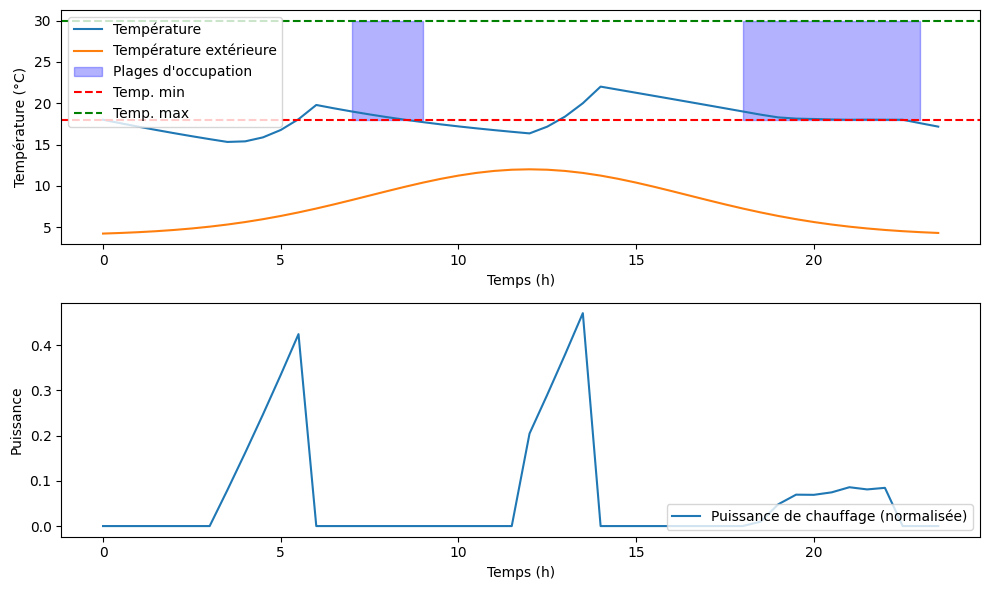

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

#définition des constantes du problème
ccr=1
cpl=1.50
Tm=18  #températures exprimées en Kelvin
TM=30 
Tin=Tm
h=0.05
k=0.01
b=1/500
N=48
PM=5000
dt=0.5
t_0=23


C=[]
for i in range (48):
    t=i*dt
    if (0<=t and t<6) or (12<=t and t<14):
        C.append(ccr)
    else:
        C.append(cpl)
C=np.array(C)


# Fonction température extérieure

def outside_temp(t):
    '''fonction renvoyant la température extérieur à une heure donnée'''
    return 4+8*np.exp((-(t-12)**2 )/40)

Te=outside_temp(np.array([i/2 for i in range (48)]))


# Contraintes
def contraintes_ineq(X):
    T = X[:N]
    P = X[N:]
    contraintes = []
    for i in range(N):
        if 7 <= i/2 % 24 < 9 or 18 <= i/2 % 24 < 23:
            # Contraintes de température pendant les heures d'occupation
            contraintes.append(T[i]-Tm)
            contraintes.append(TM-T[i] )
            
        # Contraintes de puissance de chauffage
        contraintes.append(P[i])
        contraintes.append(PM-P[i])

    return np.array(contraintes)



def contraintes_eq(X):
    T = X[:N]
    P = X[N:]
    contraintes = [T[0]-Tin]
    for i in range(N-1):
        contraintes.append(np.exp(-(k+h)*dt)*T[i]+((1-np.exp(-(k+h)*dt))/(k+h))*(b*P[i]+h*Te[i])-T[i+1])
    return np.array(contraintes)

# Fonction objectif à minimiser
def cost(X):
    Power = X[N:]
    return np.sum(np.array(Power)*C)


# Initialisation des variables
X0 = np.zeros(2 * N)
X0[:N] = (TM+Tm)/2  # Température initiale

# Définition des contraintes et de la fonction objectif pour minimize
contraintes_dict = ({'type': 'eq', 'fun': contraintes_eq},{'type': 'ineq', 'fun': contraintes_ineq})

# Résolution avec minimize
resultat_minimize = minimize(cost, X0, constraints=contraintes_dict, options={'disp': False})

# Récupération des résultats
T_resultat = resultat_minimize.x[:N]
P_resultat = resultat_minimize.x[N:]


# Affichage des résultats
temps = np.arange(0, N/2, 0.5)
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(temps, T_resultat, label='Température')
plt.plot(temps, Te, label='Température extérieure')

plt.fill_between([7,9], Tm, TM, alpha=0.3, color='blue', label='Plages d\'occupation')
plt.fill_between([18,23], Tm, TM, alpha=0.3, color='blue')
plt.axhline(y=Tm, color='r', linestyle='--', label='Temp. min')
plt.axhline(y=TM, color='g', linestyle='--', label='Temp. max')
plt.xlabel('Temps (h)')
plt.ylabel('Température (°C)')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(temps, P_resultat / PM, label='Puissance de chauffage (normalisée)')
plt.xlabel('Temps (h)')
plt.ylabel('Puissance')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()
